# Heat equation (numerically)  

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
from skimage.color import rgba2rgb
import numba
from numba import jit

The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

in two dimensions and in discrete form, can be written as

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [23]:
edge = np.linspace(0,1,100)
xv,yv = np.meshgrid(edge,edge)
img_rgb = color.rgba2rgb(io.imread('../../Desktop/computational_physics/turkey.png'))
img = color.rgb2gray(img_rgb)

In [24]:
img = np.flip(img)

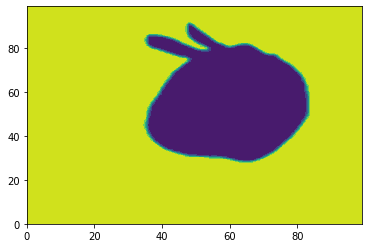

In [25]:
plt.contourf(img)

In [26]:
#Oven is a constant temp so we wanna updat only the blue region
#At each snapshot oven will be constant
turkey_bool =img<0.9
turkey_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [27]:
a_turk= 1.32e-7
rawturk_temp = 273.15 + 25
oven_temp = 273.15 + 165

Set the turkey to the initial turkey temperature and the oven to the preheated oven temperature

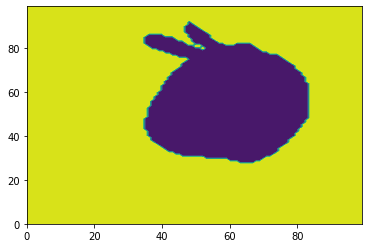

In [28]:
init_heat= np.zeros([100,100]) + oven_temp
init_heat[turkey_bool] = rawturk_temp
plt.contourf(init_heat)


Get:
1. Number of diff equation update iterations *times*
2. number of snapshots we will take *times_snapshot*
3. The array of snapshots we will take of the turkey

In [31]:
#we will take only snapshots every few updates (10)
times=36000
times_snapshot = 3600
f = int(times/times_snapshot)
#photo album of 2d array
heat_frames = np.zeros([times_snapshot,100,100])
heat_frames[0,:,:]= init_heat
heat_frames


array([[[438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
        [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
        [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
        ...,
        [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
        [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
        [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0

Set the dimensions of the problem

In [33]:
x=0.5
dx=0.5/100
dt=1. #1s so for 10 hour cooking


Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [34]:
a_turk*dt/dx**2

0.005279999999999999

In [37]:
@numba.jit("f8[:,:,:](f8[:,:,:],b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_turkey):
    cs = heatmap[0].copy()   #current state
    length = len(cs[0])
    cf=0 #current frame
    for t in range(1,times):
        ns =cs.copy() #new state
        for i in range(1,length-1):
            for j in range(1,length-1):
                if is_turkey[j][i]:
                    a=a_turk
                    ns[j][i]= cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs=ns.copy()
        if t%f==0:
            cf =cf+1
            heatmap[cf]=cs
    return heatmap

Get heat snaps in Kelvin

In [38]:
heat_frames = solve_heat(heat_frames, turkey_bool)

In [39]:
heat_frames-=273.15

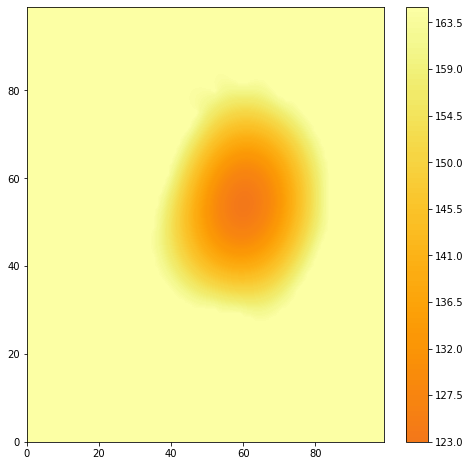

In [42]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[-1],100,cmap=my_cmap,vmin=rawturk_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)

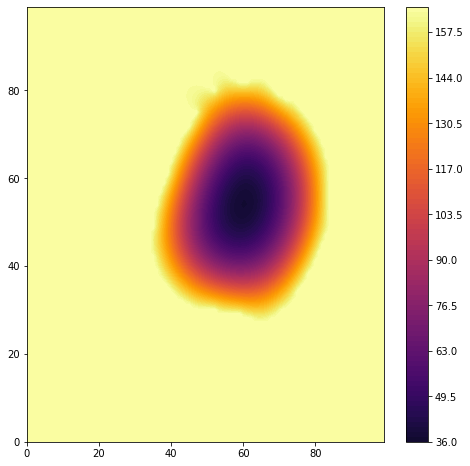

In [43]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[1000],100,cmap=my_cmap,vmin=rawturk_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)

/opt/homebrew/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


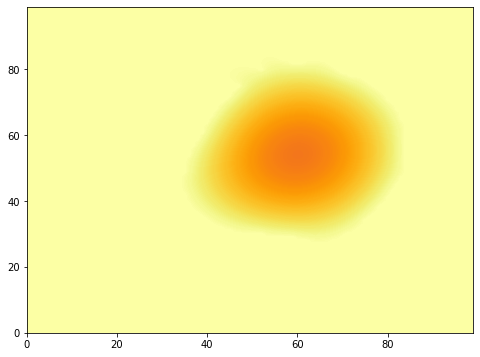

In [45]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i],100,cmap=my_cmap, vmin=rawturk_temp-273.15,vmax=oven_temp-273.15)
    return fig
fig,ax=plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate, frames=359, interval=50)
ani.save('cooked.gif', writer='pillow',fps=30)